## Project 4 - Tide Prediction Using Bayesian Linear Regression

**Exercise 1:**

Create a Bayesian Regression class that takes a log posteriori, data points, number of walkers, etc as initilization and provides all required methods and attributes required for Bayesian Regression Problems. The class should also be able to provide an integration method that allows you to integrate with respect to the posteriori distribution. Additionally, the class should allow to calculate all probabilities including the predictive distribution. Also include methods for visualization such as corner maps. Even though this class is part of a project you should consider it as your first self build Data Science tool. 

## Bayesian Class Description

This class was built to be flexible enought to take any set of arguments for a Bayesian Linear Regression. Any items that would be unique to the distribution are inputs, and are detailed below.

### Arguments

atom - The basic building block of the log-likelihood distirubtion (PDF/PMF), it is a two variable lambda function and contains any constraints required by the distribution (e.g. making sure no log is taken of negative values). This atom is then summed within the class init and made into a single variable lambda using a comprehension with the self.data variable.

prior - this is the log prior distribution, simple and straighforward. It is a lambda function with a single variable, to match the single variable of the summed atom function (the full log-likelihood function).

observations - this passes the dataset into the class.

walkers - the number of walkers to use in emcee.

var_names - a list of the names of the variables in the mu function. Since this is also the number of variables, this list is used to determine the number of variables for emcee.

Reg - this is the regression formula used to plot the regression vs the sample data. This varies enough from the atom that it seems more efficient to put this in seperately than have the class try to adjust. This function is put in as an argument when you call for the regression plot (not when the class is created).

Predict - this is the predictive distribution, it is just different enough from the regression that the two can't be shared.

#### Bonus Arguments

P_gt - Inputs are a the P_gt function and the height you want to compare. This function gives you the probability the tide is greater than the provided measure.

P_lt - Inputs are a the P_lt function and the height you want to compare. This function gives you the probability the tide is less than the provided measure.

Both these function use the same bonus_mc method within the class, so if you wanted to check if a result was within a range, the boolean logic goes in side the function that is passed into the class (as with P_gt and P_lt above).

In [1]:
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad, nquad
from scipy.special import gamma
%matplotlib inline

class bayes:
    """The bayes class takes all necessary inputs and provides the tools to do a point
    estimation based on the smallest loss. Integration is handled using Marcov Chain Monte
    Carlo analysis. The arguments are: log_func of the posterior function, observation data (list), # walkers,
    # dimensions (parameters to solve), then a list of strings for the variable names inside the log function
    for a fixed variance, make the lamba variable (fixed but unkown) the last arg.
    Only works with independent variables
    """
    
    
    # to consider: the number of dimensions will vary, but depend upon how many items in theta, maybe input theta?
    
    def __init__(self, atom, prior, observations, walkers, var_names):
        atom_log = atom # two variable function
        prior_log = prior
        like_log = lambda x: np.sum([atom_log(x)(e) for e in self.data])
        lnprob = lambda x: like_log(x) + prior_log(x)
        
        self.data = observations # list of observed data
        self.nwalkers = walkers # number of MCMC walkers
        self.ndim = len(var_names) # number of dimensions for walkers, should be # of variables to solve
        self.N = len(self.data)
        self.names = var_names
        self.MC = []
        
        # markov chain is run as part of init since it does not like the use of self. functions
        # notice the above functions are not self., only the self.samples are needed outside init.
        p0 = np.random.rand(self.nwalkers*self.ndim).reshape((self.nwalkers,self.ndim))
        self.sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, lnprob)
        pos, prob, state = self.sampler.run_mcmc(p0, 100)
        self.sampler.reset()
        pos, prob, state = self.sampler.run_mcmc(pos, 100000)
        self.samples = self.sampler.flatchain
        # self.N is set here as it is used in a number of other methods
        self.N = len(self.samples)
   
    def dataplot(self):
        X = [x[0] for x in self.data]
        T = [x[1] for x in self.data]
        fig, ax = plt.subplots(1,1, figsize = (5,3))
        ax.scatter(T,X)
        ax.set_xlabel('$time$')
        ax.set_ylabel('$Tide Height$')
        ax.grid()

    # version of MonteCarlo method used to calculate model parameters
    def parameters(self):
        # model parameters set as a list, then zipped with the list of variable names
        self.MC = [1/float(self.N)*sum([x[q] for x in self.samples]) for q in range(len(self.names))]
        params = zip(self.names,self.MC)
        print (params)
        
    def reg(self, Reg0):
        Tval = np.arange(0,7)
        m = self.MC
        Reg = np.array([Reg0(t)(m) for t in Tval])
        self.large = max(Reg)
        X = [x[0] for x in self.data]
        T = [x[1] for x in self.data]
        fig, ax = plt.subplots(1,1, figsize = (8,6))
        ax.scatter(T,X)
        ax.plot(Tval, Reg, label ='Bayesian Linear Regression', color = 'red')
        ax.set_xlabel('$time$')
        ax.set_ylabel('$Tide Height$')
        ax.legend(loc = 'best', fontsize='small')
        ax.grid()

#   This is MonteCarlo for the predictive distribution
    def pd_mc(self,func):
        return 1./self.N*np.sum([func(x) for x in self.samples])

    def predict_dist(self, time, func):
        self.time = time
        self.f = func
        predictiveDist = lambda x:\
                        np.vectorize(lambda t: self.pd_mc(lambda d: self.f(t,x)(d)))
        Xval = np.arange(0,2*self.large)
        plt.plot(Xval,predictiveDist(self.time)(Xval)) 

    def param_dist(self):
        data = pd.DataFrame(self.samples, columns = self.names)
        data.plot(kind = 'density')
        
    def corners(self):
        fig = corner.corner(self.samples, labels= self.names)

    # This MonteCarlo is used for calculating probabilites that result will be greater than a measure
    # to get less than, make the measure negative
    def bonus_mc(self,func,measure):
        Tval = np.random.uniform(0,2*np.pi,self.N)
        return 1./self.N*np.sum(func(measure)(Tval,self.samples))


**Exercise 2:**

The data below is in the form (x,t) and represents the height x of the tide at a specific location over the course of a day. Time is represented by the variable t. Build a Bayesian Regression Model using your class from Exercise 1. Show us what your new class can do!
* Start by describing the data. What type of functional behavior do you anticipate? 
* Use your model to make a prediction about the future. 
* Create a corner plot.
* What can you say about the variance of your model parameters and what does that mean?

*Bonus!!* 
* What is the probability that the tide is higher than 15 during a day.
* What is the probability that the tide is lower than 5 during a day.

In [2]:
data = [(12.676817787115283, 4.840968499185621),
 (3.0635215093963133, 3.14922059397124),
 (8.9357879700357667, 5.431164887988198),
 (13.150389074317657, 0.2734372074578954),
 (12.925121692101902, 5.02106046462978),
 (10.269853674176913, 3.7776881451798454),
 (8.5618490817719284, 1.7531496843623315),
 (11.652310665546354, 0.13740741237008774),
 (15.785676964359141, 0.1589401373556326),
 (10.709910995988764, 1.405806821770987),
 (7.1341191045745171, 5.791539306670335),
 (21.883583042704814, 5.375575646320319),
 (9.3509495831601566, 1.5283167578387404),
 (8.9421204746670746, 1.2943521169392636),
 (7.9107785943448947, 2.41326855106268),
 (6.6761875778137583, 5.605375440538395),
 (11.650996974527924, 4.935997586415922),
 (17.290020321649969, 5.274010438371379),
 (13.06634684581484, 0.2347909715055829),
 (9.2602800850011402, 1.9716673533870746),
 (13.919837953941261, 5.528598466510076),
 (7.9171739378319606, 5.84750784658713),
 (12.864499776009934, 0.8278490177929644),
 (10.571617689971236, 2.36723797633488),
 (15.697626403745566, 6.217581078023053),
 (6.9542139194365262, 3.1860455750181425),
 (13.120156492593505, 4.864593354788696),
 (11.454973850882114, 1.8798442605946453),
 (10.614021877252608, 0.8044135861997307),
 (7.568300166951679, 2.673290291826998),
 (10.183500038106194, 1.309623551484031),
 (13.503996786942462, 0.04020573153381622),
 (14.908454853041013, 5.049774593191907),
 (16.502324161297746, 5.406433813862234),
 (7.7831240000772652, 5.45198929005635),
 (2.7144705188261025, 4.10012261788714),
 (6.3268913726889187, 5.6611505113173575),
 (9.343465517423013, 3.2971190116581632),
 (10.029091959312348, 0.5986208146884879),
 (12.078957723820951, 0.3853462849024228),
 (12.542705834818268, 1.5820979005652125),
 (9.8489274946698337, 2.6735253975153426),
 (11.349497927312719, 1.1055955472925354),
 (11.06556939865615, 2.5611692213120962),
 (11.242786106546351, 0.6500902431293415),
 (7.5720317139333542, 3.4428084142928075),
 (10.19301456907124, 2.427329872753534),
 (11.688185995125892, 0.14941531339444405),
 (13.321217017544326, 4.226862591173392),
 (9.2226853401109601, 2.3990630763955374),
 (7.0737562512314449, 0.8821159241146929),
 (5.5158907409668556, 2.287657630597947),
 (5.2424711689478309, 3.4418528431658317),
 (11.826235109408199, 3.3038133315910185),
 (6.2478202112864949, 3.7493402648869223),
 (7.2776616254733053, 2.666108760536187),
 (14.728663233221567, 5.923646379789856),
 (11.088563226667782, 2.974838497958867),
 (11.458847468046265, 1.2931851555147837),
 (4.0709653063610656, 2.4390760560779694),
 (15.530850378396899, 0.7685325485891545),
 (11.615168564683962, 2.7271570577326223),
 (10.632288760396049, 5.37570954124343),
 (6.9102179020649883, 1.9530381191410195),
 (7.1344237045084675, 1.6373486764522571),
 (2.4211573415830188, 2.810112760589519),
 (7.6108111175276107, 4.181915055702122),
 (9.6538205198090434, 4.444382820070389),
 (8.1905132263562983, 3.0534156042900285),
 (7.4546566492388493, 5.388475797989607),
 (14.087818085722649, 4.961727257154151),
 (7.2780971375915371, 2.54178907740794),
 (13.49355600611988, 2.493864649506947),
 (7.1166182479555999, 3.0195450895358524),
 (13.861336288014931, 6.246482002469356),
 (9.9498449141955589, 1.5817110088866608),
 (12.090250168282912, 3.990269038499848),
 (14.0111497595614, 0.9108297343631235),
 (9.3928518482934216, 3.3950553805254793),
 (8.2709147406350212, 3.214121983305056),
 (8.386404092046515, 2.1119573572471135),
 (6.9673744914092852, 2.2083135342567983),
 (9.5162641851488523, 3.2184133097802943),
 (17.967580316152478, 3.965622119805391),
 (15.832368008468372, 0.828357131652206),
 (5.3317615928107358, 2.6644501925548774),
 (5.8971983697046877, 3.0341229253117494),
 (17.963906775041007, 6.0469989006758444),
 (5.6300726881847361, 2.4077579346402826),
 (11.348534324413565, 3.8699231013565725),
 (10.028167958705753, 1.9397974132848168),
 (14.062219131934697, 4.41603067403343),
 (9.10707255345568, 0.8011371320017451),
 (10.567716164156263, 4.450436137829604),
 (10.928830310193101, 4.839816330906595),
 (11.681478622619728, 0.8572196990559613),
 (11.538949263967641, 5.760338188965996),
 (10.978084516398958, 4.49756314191279),
 (12.818751132975834, 4.411544813273495),
 (6.7181748281785731, 5.484421751460473)]


### Data Description

While scattered, the data does appear to be taking on a sinusoidal shape. I started with a function that has factors for various aspects of the sinusoidal function, see below, but since it is not linear I converted it to a linear approximation of the function.

#### Wave Model based on Sinusoidal Function
$$tide = a*sin(b*(t + c)) + d$$
    

These characteristics adjust as described below:

* a = amplitude

* b = cycles from 0 to 2pi

    * period =  2pi/B

* c = horizontal shift (sometimes called "phase shift" when B = 1)

* d = vertical shift (or displacement)

This equation is roughly linearized by the following:    
$$tide = a' + (b'*sin(t) + c'*cos(t))$$

The variables in the linearlized version are a different set than those above.


source: http://www.regentsprep.org/regents/math/algtrig/att7/sinusoidal.htm

## Likelihood (log of atom)

Take the normal distribution with $\lambda(t) =\lambda_0$ for a fixed and known value $\lambda_0$ and 
<br /><br />
$$\mu(t) = \omega_0 + \omega_1 \sin(t) + \omega_2 \cos(t)$$
<br />
So the resulting wave height equation:

$$X_t \sim \sqrt{\frac{\lambda_0}{2 \pi}}e^{\frac{-\lambda_0}{2}(x - (\omega_0 + \omega_1 \sin(t) + \omega_2 \cos(t)))^2}$$

remove 2$\pi$ as it is not impacted by taking the log, then take the log:

$$log(likelihood \  atom) = \frac{1}{2}log(\lambda_0) - \frac{\lambda_0}{2} (x - (\omega_0 + \omega_1 \sin(t) + \omega_2 \cos(t)))^2$$


Showing the above in terms of x & e where e is the list of data tuples: 

$$\frac{1}{2}log(x[3]) - \frac{x[3]}{2} (e[0] - (x[0] + x[1] \sin(t) + x[2] \cos(t)))^2 $$

## Log Prior
 
For the Prior $\pi$ we chose the following over $\omega_0,\omega_1, \omega_2, \omega_3$ *(holding $\lambda$ constant)*:

$$\pi(\omega_0,\omega_1,\omega_2, \lambda) = \frac{1}{2 \pi} e^{-\frac{1}{2}\omega_0^2}e^{-\frac{1}{2}\omega_1^2}e^{-\frac{1}{2}\omega_2^2} e^{-\lambda_0}$$

the log prior is:

$$ =  {-\frac{1}{2}\omega_0^2} - {\frac{1}{2}\omega_1^2}- {\frac{1}{2}\omega_2^2} - {\lambda_0}$$


In [19]:
"""
The class is to be fed anything that is specific to the distribution being analyzed:
1) the log of the atom of the likelihood (2 variable lambda function)
2) the log prior (1 variable lambda function)
3) the data
4) the number of walkers
5) a list of the variable names (also used to dervie # of variables)
7) the regression formula (2 variable lambda function, called when regression method is used)
8) Predict is used for the predictive distribution (called when predictive method is used), 
    this based on predicted variables, so it should be run after self.Parameter and 
    self.regression since the max regression value is used 
    to set the top of the range for predictive dist (2.5*max(regression))
"""

atom_log = lambda x: lambda e: -np.infty if x[3] <0 else\
                                0.5 * np.log(x[3]) -(x[3]/2) *\
                                (e[0] - (x[0]+x[1]*np.sin(e[1]) + x[2]*np.cos(e[1])))**2

prior_log = lambda x: -0.5 * (x[0]**2 + x[1]**2 + x[2]**2 ) - x[3] 

var_names = ['Omega0', 'Omega1', 'Omega2', 'Lambda']

Reg = lambda t: lambda m: m[0] + m[1]*np.sin(t) + m[2]*np.cos(t)

# this is for the predictive distribution
Predict = lambda x, t: lambda d: np.sqrt(d[3]/(3*np.pi)) *\
                                np.exp(-0.5 * d[3] * (x - (d[0] + d[1]* np.sin(t) + d[2]\
                                        * np.cos(t)))**2)

    
# from Phillipa's code, use to adjust my predictors
# np.random.normal(s[i][0] + s[i][1]*np.sin(t[i])+s[i][2]*np.cos(t[i]),1./np.sqrt(s[i][3]))
    
# Below is for the bonus calculations (gt shortand for greater than)
P_gt =  lambda measure: lambda t, m: [1 for i in range(len(m))\
        if (np.random.normal(m[i][0] + m[i][1]*np.sin(t[i])+m[i][2]*np.cos(t[i]),\
                             1./np.sqrt(m[i][3])))>measure]

# Below is for the bonus calculations (lt shortand for greater than)
P_lt =  lambda measure: lambda t, m: [1 for i in range(len(m))\
        if (np.random.normal(m[i][0]+m[i][1]*np.sin(t[i])+m[i][2]*np.cos(t[i]),\
                             1./np.sqrt(m[i][3])))< measure]

In [4]:
# This creates the object of class bayes

tides = bayes(atom_log, prior_log, data, 20, var_names)

# <font color='blue'> This next segment saves & reloads the samples so it will not have to be rerun
</font>

In [5]:
MC_samples = pd.DataFrame(tides.samples)
MC_samples.to_csv('MC_samples.csv')

In [6]:
samples = np.array(pd.read_csv('MC_samples.csv',\
                               usecols=[1,2,3,4]).values.tolist())
N = len(samples)
# adjust # of columns to use depending on file - should be 4 for this case

In [7]:
tides.parameters() # uses Monte Carlo to solve for main parameters

[('Omega0', 9.4671066432088828), ('Omega1', -0.63164974696125809), ('Omega2', 1.7704891930854634), ('Lambda', 0.095616719911252188)]


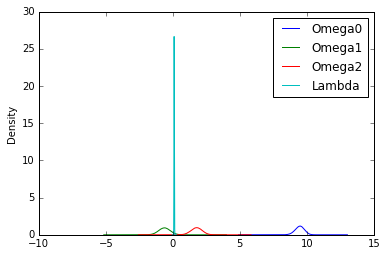

In [8]:
tides.param_dist() # distribution of the parameters

### Parameter disribution

The lamda prediction is fairly tight/precise while the 3 omega parameters seem fairly good - just poor in comparison to the lambda prediction.

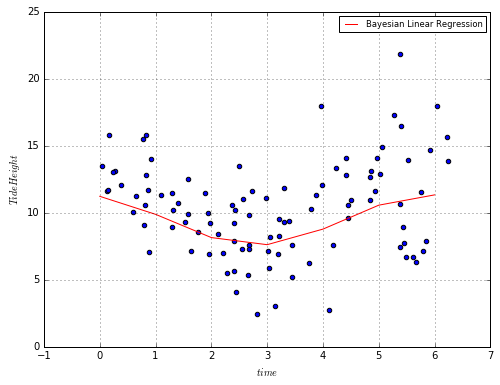

In [9]:
tides.reg(Reg) # Reg is the regression formula, run after parameters

### Future Prediction
The snippet below is the probablity distribution of the tide height at time = 10.

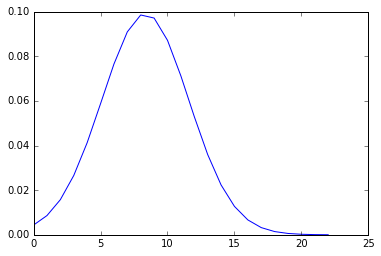

In [10]:
# Run predict_dist after reg method, as the max in reg is used to set upper limit for predict_dist

tides.predict_dist(10,Predict) # First argument is the time, 2nd is the predictive distribution

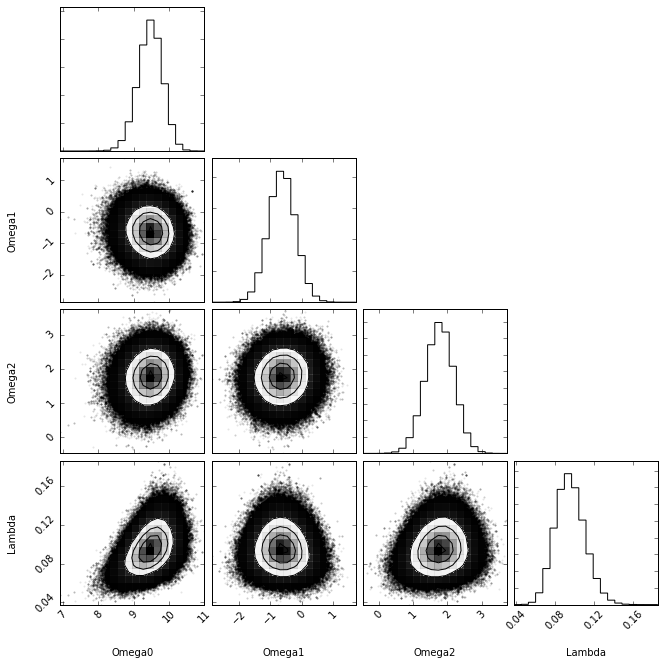

In [11]:
tides.corners()

## Bonus

Given the model parameters, predict how often tide height is 1) above 15, 2) below 5

From the results below, the model does not quite reach either threshold, with no waves going above 14 feet or below 5 feet. I thought this was likely influenced by two factors. The linearization of the model brings the sine wave in a little lower than would be expected (by visual inspection) and also maybe the sample size was too small. On the second item, the data below is for 2,000,000 samples (20 walkers, 100,000 steps). An earlier run at 200,000 samples did not have waves go below 6 feet. So increasing the sample size 10 fold did change the profile slightly. So, instead of the sample size being too small, I believe the variance on the model parameters (omegas and lambda) is too small to allow for much variation in the data.

One last thought. A non-linear function may be better able to compensate for varying the frequency of the wave (so the period is different from 2 Pi. Further development of this to work with both linear and non-linear functions would enable this exploration.



In [17]:
# Check probablity of tides above a certain height
# this feeds in the function for checking greater than, and also the tide height,
# looped to provide profile
for i in range(18):
    print('Probability of Tides above {0}: {1}'.format(i,tides.bonus_mc(P_gt,i)))


Probability of Tides above 0: 0.995655
Probability of Tides above 1: 0.990742
Probability of Tides above 2: 0.9810355
Probability of Tides above 3: 0.964189
Probability of Tides above 4: 0.9366025
Probability of Tides above 5: 0.8941285
Probability of Tides above 6: 0.833969
Probability of Tides above 7: 0.7552465
Probability of Tides above 8: 0.6601765
Probability of Tides above 9: 0.552794
Probability of Tides above 10: 0.441725
Probability of Tides above 11: 0.333792
Probability of Tides above 12: 0.2393655
Probability of Tides above 13: 0.161605
Probability of Tides above 14: 0.101856
Probability of Tides above 15: 0.0602545
Probability of Tides above 16: 0.033277
Probability of Tides above 17: 0.0171975


In [20]:
# Check probablity of tides below a certain height
# this feeds in the function for checking less than, and also the tide height, 
# looped to provide profile
for i in range(18):
    print('Probability of Tides below {0}: {1}'.format(i,tides.bonus_mc(P_lt,i)))


Probability of Tides below 0: 0.004258
Probability of Tides below 1: 0.0092735
Probability of Tides below 2: 0.0188725
Probability of Tides below 3: 0.0356945
Probability of Tides below 4: 0.06331
Probability of Tides below 5: 0.1057815
Probability of Tides below 6: 0.165857
Probability of Tides below 7: 0.2445405
Probability of Tides below 8: 0.3401005
Probability of Tides below 9: 0.447582
Probability of Tides below 10: 0.558003
Probability of Tides below 11: 0.664765
Probability of Tides below 12: 0.7603035
Probability of Tides below 13: 0.8380835
Probability of Tides below 14: 0.898108
Probability of Tides below 15: 0.939635
Probability of Tides below 16: 0.9666535
Probability of Tides below 17: 0.98267


## Next Steps

Improvements that could be made:

1. Streamline the internal functions, if possible. On the current run through, I could not envision a way to share some resources (such as the atom of the likelihood, or the MC integration method) as each was built for an initial task. Now having worked through all the funcitoinality, a review of the process could lead to further streamlining of the methods.

2. Build a second path for non-linear functions. In the first iteration I focused on building this for a linear function. Further development could add the tools (mainly monte carlo) for working with non-linear functions.